In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import scipy
import skimage
import tensorflow as tf
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './dataset/notmnist' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./dataset/notmnist/notMNIST_large.tar.gz
Found and verified ./dataset/notmnist/notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders  = maybe_extract(test_filename)

./dataset/notmnist/notMNIST_large already present - Skipping extraction of ./dataset/notmnist/notMNIST_large.tar.gz.
['./dataset/notmnist/notMNIST_large/A', './dataset/notmnist/notMNIST_large/B', './dataset/notmnist/notMNIST_large/C', './dataset/notmnist/notMNIST_large/D', './dataset/notmnist/notMNIST_large/E', './dataset/notmnist/notMNIST_large/F', './dataset/notmnist/notMNIST_large/G', './dataset/notmnist/notMNIST_large/H', './dataset/notmnist/notMNIST_large/I', './dataset/notmnist/notMNIST_large/J']
./dataset/notmnist/notMNIST_small already present - Skipping extraction of ./dataset/notmnist/notMNIST_small.tar.gz.
['./dataset/notmnist/notMNIST_small/A', './dataset/notmnist/notMNIST_small/B', './dataset/notmnist/notMNIST_small/C', './dataset/notmnist/notMNIST_small/D', './dataset/notmnist/notMNIST_small/E', './dataset/notmnist/notMNIST_small/F', './dataset/notmnist/notMNIST_small/G', './dataset/notmnist/notMNIST_small/H', './dataset/notmnist/notMNIST_small/I', './dataset/notmnist/not

In [4]:
import random

# Visualise a sample of each label
def display_images(filename, samples_per_label):
    print ('Displaying images in: ', filename)
    folder = os.path.join(data_root, filename)
    for label in sorted(os.listdir(folder)):
        if(label.endswith('.pickle') == False):
            print ('Label: ', label)
            label_folder = os.path.join(folder, label)
            dirs = os.listdir(label_folder)
            random.shuffle(dirs)
            for image in dirs[:samples_per_label]:
                display(Image(filename=os.path.join(label_folder, image), width=20.0, height=20.0))
            
display_images('notMNIST_large', 5)
display_images('notMNIST_small', 5)

Displaying images in:  notMNIST_large
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


Displaying images in:  notMNIST_small
Label:  A


Label:  B


Label:  C


Label:  D


Label:  E


Label:  F


Label:  G


Label:  H


Label:  I


Label:  J


In [5]:
def saveAsPickle(data,filename):
    try:
        with open(filename, 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
            print (filename + " pickled!")
    except Exception as e:
        print('Unable to save data to', filename, ':', e)
        
def loadPickle(file):
    with open(file, 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            saveAsPickle(dataset, set_filename)
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./dataset/notmnist/notMNIST_large/A.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/B.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/C.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/D.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/E.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/F.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/G.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/H.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/I.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_large/J.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/A.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/B.pickle already present - Skipping pickling.
./dataset/notmnist/notMNIST_small/C.pick

Displaying pickles from train dataset


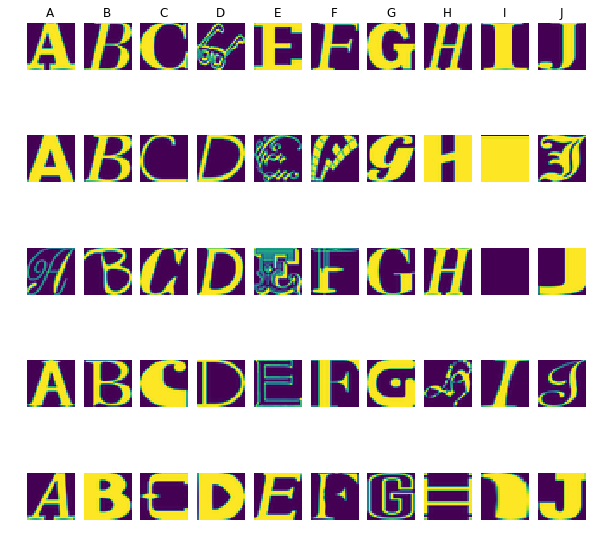

Displaying pickles from test dataset


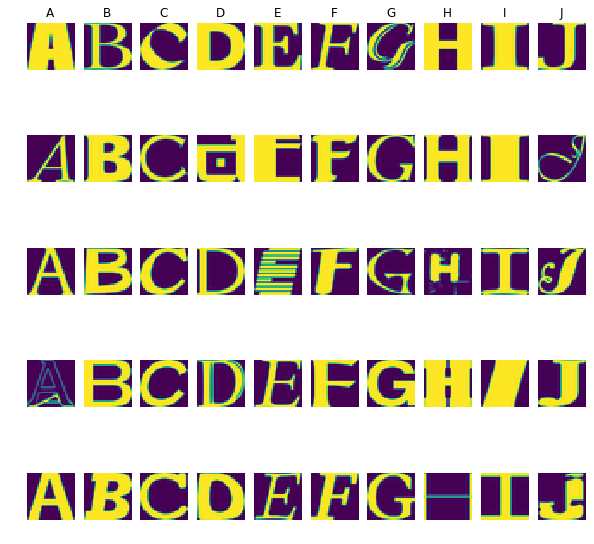

In [7]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_labels = len(labels)

def display_pickle(dataset, samples_per_label):
    for y, label in enumerate(labels):
        pickles = loadPickle(dataset[y])
        idxs = np.random.choice(pickles.shape[0], samples_per_label, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_labels + y + 1
            plt.subplot(samples_per_label, num_labels, plt_idx)
            plt.imshow(pickles[idx, :, :])
            plt.axis('off')
            if i == 0:
                plt.title(label)
    plt.show()
    

print ('Displaying pickles from train dataset')
display_pickle(train_datasets, 5)
print ('Displaying pickles from test dataset')
display_pickle(test_datasets, 5)

In [8]:
# Verify if the data is balanced across classes
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_labels = len(labels)

def print_num_example(dataset):
    for y, label in enumerate(labels):
        pickles = loadPickle(dataset[y])
        print ('Label: %s --- num example: %d' % (label, pickles.shape[0]))

print ('Train Dataset')
print_num_example(train_datasets)
print ('Test Dataset')
print_num_example(test_datasets)

Train Dataset
Label: A --- num example: 52909
Label: B --- num example: 52911
Label: C --- num example: 52912
Label: D --- num example: 52911
Label: E --- num example: 52912
Label: F --- num example: 52912
Label: G --- num example: 52912
Label: H --- num example: 52912
Label: I --- num example: 52912
Label: J --- num example: 52911
Test Dataset
Label: A --- num example: 1872
Label: B --- num example: 1873
Label: C --- num example: 1873
Label: D --- num example: 1873
Label: E --- num example: 1873
Label: F --- num example: 1872
Label: G --- num example: 1872
Label: H --- num example: 1872
Label: I --- num example: 1872
Label: J --- num example: 1872


In [9]:
img_size = image_size
new_size = (28, 56)

def make_arrays(nb_rows, size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, size[0], size[1]), dtype=np.float32)
        labels = np.ndarray((nb_rows, 6), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, dataset_size):
    dataset, labels = make_arrays(dataset_size, new_size)
    pickles = []
    for i in range(10):
        pickles.append(pickle.load(open(pickle_files[i], 'rb')))

    for i in range(dataset_size):
        # Generate a random label with max length 5 chars
        data_length  = np.random.choice(5, 1)[0] + 1
#         data_length = 5
#         random_chars = np.random.choice(10, data_length)
        random_chars = np.random.choice(9, data_length)
        data_label   = np.append(random_chars, np.full(5 - data_length, 0, dtype=int))
        data_label   = np.insert(data_label, 0, data_length - 1)
        
        chars = []
        
        for char in random_chars:
            index = np.random.choice(len(pickles[char]), 1)
            chars.append(np.reshape(pickles[char][index, :, :], (img_size, img_size)))

        image = np.ndarray((img_size, data_length * img_size))
        
        for idx, char in enumerate(chars):
            image[:, img_size*idx:img_size*(idx+1)] = char

        image = skimage.transform.resize(image, new_size)

        dataset[i] = image
        labels[i]  = data_label
    return (dataset, labels)

if not os.path.exists(os.path.join(data_root, 'train_length.pickle')):
    train = merge_datasets(train_datasets, 200000)
    saveAsPickle(train, os.path.join(data_root, 'train_length.pickle'))
else:
    print('Train Datasets already exists')
    train = loadPickle(os.path.join(data_root, 'train_length.pickle'))    
if not os.path.exists(os.path.join(data_root, 'valid_length.pickle')):
    valid = merge_datasets(train_datasets, 5000)
    saveAsPickle(valid, os.path.join(data_root, 'valid_length.pickle'))
else:
    print('Validation Datasets already exists')
    valid = loadPickle(os.path.join(data_root, 'valid_length.pickle'))    
if not os.path.exists(os.path.join(data_root, 'test_length.pickle')):
    test  = merge_datasets(test_datasets, 10000)
    saveAsPickle(test, os.path.join(data_root, 'test.pickle'))
else:
    print('Test Datasets already exists')
    test  = loadPickle(os.path.join(data_root, 'test.pickle'))

Train Datasets already exists
Validation Datasets already exists


/Users/brunonishimoto/anaconda3/envs/udacity/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/brunonishimoto/anaconda3/envs/udacity/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


./dataset/notmnist/test.pickle pickled!


In [10]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train[0], train[1])
test_dataset, test_labels = randomize(test[0], test[1])
valid_dataset, valid_labels = randomize(valid[0], valid[1])

Displaying training images
[[2 7 8 5 0 0]
 [3 0 4 7 0 0]
 [0 7 0 0 0 0]]


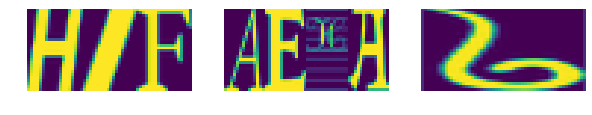

Displaying test images
[[2 1 1 4 0 0]
 [2 5 6 7 0 0]
 [0 1 0 0 0 0]]


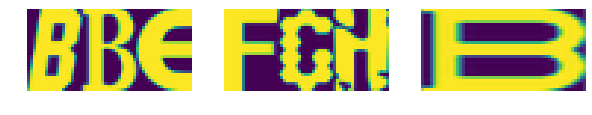

Displaying validation images
[[1 1 3 0 0 0]
 [1 8 0 0 0 0]
 [1 7 5 0 0 0]]


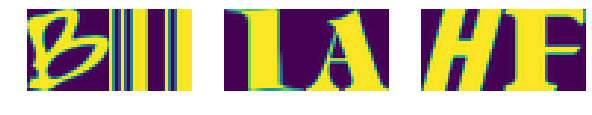

In [11]:
def display_dataset(dataset, labels, samples_per_label):
    idxs = np.random.choice(dataset.shape[0], samples_per_label, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i + 1
        plt.subplot(1, samples_per_label, plt_idx)
        plt.imshow(dataset[idx])
        plt.axis('off')
    print(labels[idxs])
    plt.show()
    
print ('Displaying training images')
display_dataset(train_dataset, train_labels, 3)
print ('Displaying test images')
display_dataset(test_dataset, test_labels, 3)
print ('Displaying validation images')
display_dataset(valid_dataset, valid_labels, 3)

In [12]:
new_size = (28, 56)
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, new_size[0], new_size[1], num_channels)).astype(np.float32)
    length_labels = np.eye(5)[labels[:, 0]]
    labels = np.eye(10)[labels[:, 1:]]
    
    return dataset, length_labels, labels

train_dataset, train_length, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_length, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_length, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_length.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_length.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_length.shape, test_labels.shape)

Training set (200000, 28, 56, 1) (200000, 5) (200000, 5, 10)
Validation set (5000, 28, 56, 1) (5000, 5) (5000, 5, 10)
Test set (10000, 28, 56, 1) (10000, 5) (10000, 5, 10)


In [13]:
def accuracy_labels(predictions, pmasked, labels, lmasked, masks, labels_length):
    predictions = np.transpose(predictions, (1, 0, 2))
    correct = np.multiply(np.argmax(predictions, 2) == np.argmax(labels, 2), np.transpose(masks))
    global_accuracy = np.mean(np.sum(correct, 1) == np.argmax(labels_length, 1) + 1) * 100
    correct_masked = [np.mean(np.argmax(pmasked[i], 1) == np.argmax(lmasked[i], 1)) * 100 for i in range(len(pmasked))]
    return [global_accuracy, correct_masked]

def accuracy_length(predictions, labels_length):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels_length, 1), 0) / predictions.shape[0])

## Network

In [14]:
batch_size = 32
patch_size = 5
depth = 32
num_hidden = 64
image_size = (28, 56)
num_outputs = 5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_data     = tf.placeholder(tf.float32, shape=(None, image_size[0], image_size[1], num_channels))
    tf_labels   = tf.placeholder(tf.float32, shape=(None, num_outputs, num_labels))
    tf_length   = tf.placeholder(tf.float32, shape=(None, num_outputs))
    tf_training = tf.placeholder(tf.bool)

    # Variables.
    ## First convolutional layer
    conv1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    conv1_biases  = tf.Variable(tf.zeros([depth]))
    
    ## Second convolutional layer
    conv2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    conv2_biases  = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    ## fully connected layer
    fc1_weights = tf.Variable(tf.truncated_normal(
        [image_size[0] // 4 * image_size[1] // 4 * depth, num_hidden], stddev=0.1))
    fc1_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    ## softmax
    softmax0_weights = tf.Variable(tf.truncated_normal([num_hidden, num_outputs], stddev=0.1))
    softmax0_biases  = tf.Variable(tf.constant(1.0, shape=[num_outputs]))
    
    softmax1_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax1_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax2_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax3_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax3_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax4_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    softmax5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    softmax5_biases  = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        # first conv
        conv   = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv1_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # second conv
        conv   = tf.nn.conv2d(hidden, conv2_weights, [1, 1, 1, 1], padding='SAME')
        conv   = tf.nn.relu(conv + conv2_biases)
        hidden = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # flatten
        shape   = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]])
        
        # fc
        hidden  = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        
        # classifiers
        classifier0 = tf.matmul(hidden, softmax0_weights) + softmax0_biases
        classifier1 = tf.matmul(hidden, softmax1_weights) + softmax1_biases
        classifier2 = tf.matmul(hidden, softmax2_weights) + softmax2_biases
        classifier3 = tf.matmul(hidden, softmax3_weights) + softmax3_biases
        classifier4 = tf.matmul(hidden, softmax4_weights) + softmax4_biases
        classifier5 = tf.matmul(hidden, softmax5_weights) + softmax5_biases
        
        return classifier0, [classifier1, classifier2, classifier3, classifier4, classifier5]
  
    # Training computation.
    logits_length, logits = model(tf_data)
    
    total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=tf_length, logits=logits_length))
    tf.summary.scalar('loss_length', total_loss)
    
    # generating a tensor (?,num_labels) where each row contains 1s, 2s, 3s,... Will be used
    fills = tf.stack([tf.fill([tf.shape(tf_data)[0]], i + 1) for i in range(0, num_outputs)])

    masks   = list()   
    dmasked = list()
    lmasked = list()
    for i in range(0, len(logits)):
        # http://stackoverflow.com/questions/34128104/tensorflow-creating-mask-of-varied-lengths
        # get a mask of logits for the first (length - 1) digits
        masks.append(tf.less_equal(fills[i], tf.argmax(tf_length, 1, output_type=tf.int32) + 1))
        dmasked.append(tf.boolean_mask(logits[i], masks[i]))
        lmasked.append(tf.boolean_mask(tf_labels[:, i], masks[i]))
        loss = tf.cond(tf.less(0, tf.shape(lmasked[i])[0]),
                        lambda: tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
                            labels=lmasked[i], logits=dmasked[i])),
                        lambda: tf.constant(0.0))

        tf.summary.scalar(f'loss_{i}', loss)
        total_loss += loss
    masks   = tf.stack(masks)
    tf.summary.scalar(f'total_loss', total_loss)
    merged  = tf.summary.merge_all()

    # Optimizer.
    optimizer = tf.cond(tf_training, lambda: tf.train.GradientDescentOptimizer(0.05).minimize(total_loss), lambda: False)
  
    # Predictions for the training, validation, and test data.
    def prediction(length, logits):
        prediction = [tf.nn.softmax(logit) for logit in logits]
        return tf.nn.softmax(length), tf.stack(prediction)
    
    def prediction_masked(logits, masks):
        return [tf.nn.softmax(tf.boolean_mask(logits[i], masks[i])) for i in range(0, len(logits))]   
    
    length_predictions, predictions = prediction(logits_length, logits)
    pmasked = prediction_masked(logits, masks)


/Users/brunonishimoto/anaconda3/envs/udacity/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
def printAccuracies(type, loss, length_acc, acc):
    print(f'\t{type} loss: {loss}')
    print(f'\t{type} accuracies: {acc[0]:.2f}')
    print(f'\tLength accuracy: {length_acc:.2f}')
    for i in range(len(acc[1])):
        print(f'\tDigit {i}: {acc[1][i]:.2f}')

In [16]:
num_steps = 7001

with tf.Session(graph=graph) as session:
    if not os.path.exists('summaries'):
        os.mkdir('summaries')
    writer = tf.summary.FileWriter('summaries', session.graph)
    
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        batch_length = train_length[offset:(offset + batch_size)]
        feed_dict = {tf_data: batch_data, tf_labels: batch_labels, tf_length: batch_length, tf_training: True}
        _, t_loss, t_length_pred, t_predictions, t_pmasked, t_masks, t_lmasked, summary = session.run(
            [optimizer, total_loss, length_predictions, predictions, pmasked,
             masks, lmasked, merged], feed_dict=feed_dict)
        writer.add_summary(summary, step)
        if (step % 100 == 0):
            train_accuracy = accuracy_labels(t_predictions, t_pmasked, batch_labels, t_lmasked, t_masks, batch_length)
            train_length_accuracy = accuracy_length(t_length_pred, batch_length)
            print(f'step {step}:')
            printAccuracies('Minibatch', t_loss, train_length_accuracy, train_accuracy)
            feed_dict = {tf_data: valid_dataset, tf_labels: valid_labels, 
                         tf_length: valid_length, tf_training: False}
            v_loss, v_length_pred, v_predictions, v_pmasked, v_masks, v_lmasked, summary = session.run(
                [total_loss, length_predictions, predictions, pmasked,
                 masks, lmasked, merged], feed_dict=feed_dict)
            valid_accuracy = accuracy_labels(v_predictions, v_pmasked, valid_labels, v_lmasked, v_masks, valid_length)
            valid_length_accuracy = accuracy_length(v_length_pred, valid_length)
            printAccuracies('Validation', v_loss, valid_length_accuracy, valid_accuracy)

    feed_dict = {tf_data: test_dataset, tf_labels: test_labels, 
                 tf_length: test_length, tf_training: False}
    test_loss, test_length_pred, test_predictions, test_pmasked, test_masks, test_lmasked = session.run(
        [total_loss, length_predictions, predictions, pmasked,
         masks, lmasked], feed_dict=feed_dict)
    test_accuracy = accuracy_labels(test_predictions, test_pmasked, test_labels, test_lmasked, test_masks, test_length)
    test_length_accuracy = accuracy_length(test_length_pred, test_length)
    printAccuracies('Test', test_loss, test_length_accuracy, test_accuracy)

Initialized
step 0:
	Minibatch loss: 4.788089752197266
	Minibatch accuracies: 0.00
	Length accuracy: 31.25
	Digit 0: 6.25
	Digit 1: 4.00
	Digit 2: 0.00
	Digit 3: 37.50
	Digit 4: 16.67
	Validation loss: 3.076775312423706
	Validation accuracies: 2.84
	Length accuracy: 19.72
	Digit 0: 11.58
	Digit 1: 12.03
	Digit 2: 11.89
	Digit 3: 8.87
	Digit 4: 12.26
step 100:
	Minibatch loss: 2.1772685050964355
	Minibatch accuracies: 6.25
	Length accuracy: 34.38
	Digit 0: 12.50
	Digit 1: 0.00
	Digit 2: 5.00
	Digit 3: 28.57
	Digit 4: 40.00
	Validation loss: 2.1782007217407227
	Validation accuracies: 4.34
	Length accuracy: 25.92
	Digit 0: 13.72
	Digit 1: 9.55
	Digit 2: 10.16
	Digit 3: 12.27
	Digit 4: 11.47
step 200:
	Minibatch loss: 2.1389997005462646
	Minibatch accuracies: 0.00
	Length accuracy: 25.00
	Digit 0: 9.38
	Digit 1: 12.50
	Digit 2: 15.79
	Digit 3: 0.00
	Digit 4: 40.00
	Validation loss: 2.1755447387695312
	Validation accuracies: 2.98
	Length accuracy: 20.52
	Digit 0: 11.72
	Digit 1: 10.91
	Digi

	Validation loss: 1.277458667755127
	Validation accuracies: 20.48
	Length accuracy: 94.30
	Digit 0: 48.74
	Digit 1: 33.79
	Digit 2: 38.84
	Digit 3: 49.63
	Digit 4: 69.79
step 2400:
	Minibatch loss: 1.167031168937683
	Minibatch accuracies: 34.38
	Length accuracy: 90.62
	Digit 0: 68.75
	Digit 1: 56.00
	Digit 2: 38.89
	Digit 3: 50.00
	Digit 4: 66.67
	Validation loss: 1.2579585313796997
	Validation accuracies: 21.00
	Length accuracy: 93.48
	Digit 0: 50.38
	Digit 1: 34.57
	Digit 2: 40.31
	Digit 3: 49.14
	Digit 4: 71.29
step 2500:
	Minibatch loss: 1.3051559925079346
	Minibatch accuracies: 12.50
	Length accuracy: 100.00
	Digit 0: 59.38
	Digit 1: 28.00
	Digit 2: 42.86
	Digit 3: 36.84
	Digit 4: 75.00
	Validation loss: 1.2009756565093994
	Validation accuracies: 22.54
	Length accuracy: 94.82
	Digit 0: 53.82
	Digit 1: 38.62
	Digit 2: 39.34
	Digit 3: 51.31
	Digit 4: 74.98
step 2600:
	Minibatch loss: 1.2488619089126587
	Minibatch accuracies: 25.00
	Length accuracy: 100.00
	Digit 0: 53.12
	Digit 1: 5

step 4700:
	Minibatch loss: 0.877962589263916
	Minibatch accuracies: 28.12
	Length accuracy: 96.88
	Digit 0: 59.38
	Digit 1: 62.07
	Digit 2: 66.67
	Digit 3: 69.23
	Digit 4: 83.33
	Validation loss: 0.8331456184387207
	Validation accuracies: 36.96
	Length accuracy: 97.42
	Digit 0: 69.78
	Digit 1: 59.88
	Digit 2: 64.31
	Digit 3: 72.30
	Digit 4: 78.86
step 4800:
	Minibatch loss: 0.7032794952392578
	Minibatch accuracies: 37.50
	Length accuracy: 93.75
	Digit 0: 68.75
	Digit 1: 64.00
	Digit 2: 61.11
	Digit 3: 90.91
	Digit 4: 100.00
	Validation loss: 0.8113452792167664
	Validation accuracies: 37.64
	Length accuracy: 97.62
	Digit 0: 70.52
	Digit 1: 61.53
	Digit 2: 65.17
	Digit 3: 71.91
	Digit 4: 81.56
step 4900:
	Minibatch loss: 0.8758176565170288
	Minibatch accuracies: 28.12
	Length accuracy: 93.75
	Digit 0: 56.25
	Digit 1: 62.96
	Digit 2: 72.22
	Digit 3: 75.00
	Digit 4: 66.67
	Validation loss: 0.8135461807250977
	Validation accuracies: 39.28
	Length accuracy: 97.96
	Digit 0: 71.18
	Digit 1: 6

	Validation loss: 0.6594639420509338
	Validation accuracies: 47.04
	Length accuracy: 98.36
	Digit 0: 76.28
	Digit 1: 71.41
	Digit 2: 74.14
	Digit 3: 79.10
	Digit 4: 82.25
	Test loss: 0.4812268912792206
	Test accuracies: 57.45
	Length accuracy: 99.01
	Digit 0: 82.95
	Digit 1: 77.79
	Digit 2: 80.67
	Digit 3: 84.97
	Digit 4: 87.27
